### MAP556, Ecole Polytechnique, 2023-24


# TP3 - The wing weight function

La fonction suivante est un modèle pour le poids de l'aile d'un avion :

$0.036*S_w^{0.758}W_{fw}^{0.0035} \left(\frac{A}{\cos^2(\Lambda)}\right)^{0.6} q^{0.006}\lambda^{0.04}\left(\frac{100t_c}{\cos(\Lambda)}\right)^{-0.3}(N_xW_{dg})^{0.49} + S_wW_p$

Elle est extraite de la bibliothèque virtuelle de fonctions de test de simulations expérimentales mise au point par Surjanovic et Bingham (2013).

Les significations et les plages des variables sont indiquées dans le tableau ci-dessous.

| Variable  | Range         | Meaning                               |
|:----------|:--------------|:--------------------------------------|
| $S_w$     | [150, 200]    | Wing Arra (ft²)                      |
| $W_{fw}$  | [220, 300]    | Weight of Fuel in the Wing (lb)          |
| $A$       | [6, 10]       | Aspect Ratio                          |
| $\Lambda$ | [-10, 10]     | Quarter-Chord Sweep (degrees)        |
| $q$       | [16, 45]      | Dynamic Pressure at Cruise (lb/ft²)  |
| $\lambda$ | [0.5, 1]      | Taper Ratio                           |
| $t_c$     | [0.08, 0.18]  | Aerofoil Thickness to Chord Ratio    |
| $N_x$     | [2.5, 6]      | Ultimate Load Factor                  |
| $W_{dg}$  | [1700, 2500]  | Flight Design Gross Weight (lb)      |
| $W_p$     | [0.025, 0.08] | Paint Weight (lb/ft²) 

La bibliothèque virtuelle contient du code pour implémenter cette fonction ainsi que des références à son origine. Notez que $\Lambda$ est donné en degrés, de −10 à 10. Il se situe alors entre $\pm 10\pi/180$ radians, donc $\cos(\Lambda)$ ne s'approche pas de zéro, et les poids des ailes sont bornés.

Nous étudierons la moyenne de cette fonction sur l’hypercube à 10 dimensions défini par les plages de ses variables d’entrée. Notre intégrande sur $[0,1]^{10}$ adapte d'abord chaque variable à sa plage, puis calcule le poids de l'aile. On ne chercherait normalement pas le poids moyen d’une aile d’avion conçue au hasard. Cet exemple est utile à titre d’illustration car il a une origine scientifique/ingénierie tout en ne nécessitant pas l’accès à un logiciel propriétaire spécialisé pour le calculer. Nous ignorerons également le fait que neuf des dix variables d’entrée peuvent être intégrées pour donner une forme élémentaire fermée. L’exception est $\Lambda$.

Nous pouvons appliquer un échantillonnage de Monte-Carlo simple ainsi qu'un échantillonnage quasi-Monte-Carlo à cet intégrande. Le but du TP est de montrer l'efficacité de la méthode quasi-Monte-Carlo en comparaison de l'échantillonnage Monte-Carlo.

### 1- Illustration de la répartition d'une suite dans [0,1]

Rappelons que la discrépance $D_N(x)$ et la discrépance étoile $D_N^*(x)$ de la suite $x=\{x_n\}_{n \geqslant 1}$ dans $[0,1]$ sont respectivement données par
$$
D_N(x) = \sup_{0\leqslant a<b \leqslant 1} \left| \frac{1}{N} \sum_{k=1}^N 1_{[a,b)}(x_k) - (b-a)\right|\,,\qquad D_N^*(x) = \sup_{ 0\leqslant a \leqslant 1} \left| \frac{1}{N} \sum_{k=1}^N 1_{[0,a)}(x_k) - a\right|.
$$

On se donne une suite de 100 points obtenue par un générateur aléatoire.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

size_sequence = 100  # Nombre de points dans la suite
sequence = np.random.random(size_sequence)

On peut afficher la suite pour visualiser la manière dont elle remplit l'intervalle $[0,1]$.

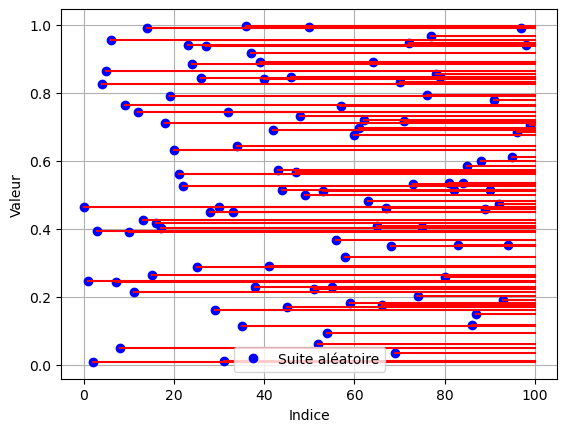

In [2]:
# Afficher la suite et son remplissage de [0,1]
plt.plot(sequence, 'bo', label='Suite aléatoire')
for i in range(size_sequence):
    plt.plot([i,size_sequence],[sequence[i],sequence[i]],'r-')

plt.xlabel('Indice')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.show()

### 2- Calcul de la discrépance

On cherche à calculer la discrépance de la suite précédente. Mais pour calculer un supremum sur $a$ et $b$ dans $[0,1]$, on est clairement face à un problème informatique. Une première idée est de se représenter une grille finie $G$ sur $[0,1]\times [0,1]$ constituée de couples de variables $(a_i,b_j)_{i\in I, j\in J}$ dans laquelle on va faire varier les variables $a$ et $b$ . En calculant la discrépance locale entre $a$ et $b$ définie par 
$$
D_N(x,a,b) = \left| \frac{1}{N} \sum_{k=1}^N 1_{[a,b)}(x_k) - (b-a)\right|,
$$
on obtient une borne inférieure de la discrépance par la formule
$$
D_N(x) \geq \sup_{(a,b)\in G} D_N(x,a,b).
$$

#### $\blacktriangleright$ Question 1 [code] : Ecrire un code python pour calculer la discrépance locale entre deux bornes $a$ et $b$. On pourra utiliser la fonction `filter(lambda x: a <= x < b, sequence)` pour extraire une sous-suite.

In [3]:
###################################################
# Réponse 1 [code] :
###################################################
def calculate_local_discrepancy(sequence,a,b):
    N = len(sequence)
    nb_in_interval = len(list(filter(lambda x: a <= x < b, sequence)))
    freq_in_interval = nb_in_interval/N
    discrepancy = abs(freq_in_interval - (b - a))
    
    return discrepancy

A l'aide de la discrépance locale, on peut alors calculer le supremum sur une grille uniforme de taille $\mathcal{O}(P^2)$ avec $G:=\left\{\left(\frac{i}{P},\frac{j}{P}\right)\right\}_{0\leq i<j\leq P}$.

In [4]:
def calculate_discrepancy_on_mesh(sequence,size_mesh):
    max_discrepancy = 0
    for i in range(0, size_mesh):
        for j in range(i + 1, size_mesh+1):
            left = i/size_mesh
            right = j/size_mesh 
            d_local = calculate_local_discrepancy(sequence,left,right)
            max_discrepancy = max(max_discrepancy, d_local)
    
    return max_discrepancy

In [5]:
# Afficher la borne inférieure de la discrépance de la suite
size_mesh = 100
discrepancy = calculate_discrepancy_on_mesh(sequence,size_mesh)
print(f'Pour une taille de maillage {size_mesh}x{size_mesh} la borne inférieure de la discrépance est {discrepancy:.4f}.')

Pour une taille de maillage 100x100 la borne inférieure de la discrépance est 0.1000.


#### $\blacktriangleright$ Question 2 [code] : La méthode n'est clairement pas optimale. Proposer une amélioration simple en choisissant astucieusement la grille $G$. On pourra s'inspirer du dessin suivant réalisé en 2D pour une meilleure visualisation. 

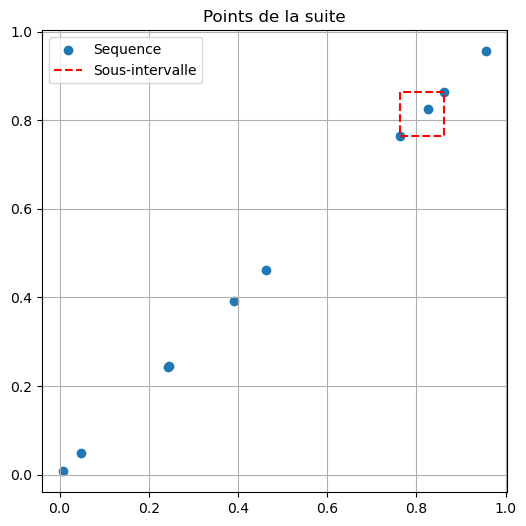

In [6]:
plt.figure(figsize=(6, 6))
plt.scatter(sequence[0:10],sequence[0:10], marker='o', label='Sequence')
plt.plot([sequence[5], sequence[9],sequence[9],sequence[5],sequence[5]], [sequence[5],sequence[5],sequence[9],sequence[9],sequence[5]], 'r--', label='Sous-intervalle')

# Afficher le graphique
plt.title('Points de la suite')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
###################################################
# Réponse 2 [code] :
###################################################
def calculate_discrepancy_sub_interval(sequence):
    N = len(sequence)
    max_discrepancy = 0 
    sorted_sequence = sorted(sequence)
    
    for i in range(N):
        for j in range(i + 1, N):
            a = sorted_sequence[i]
            b = sorted_sequence[j]
            nb_in_interval = len(list(filter(lambda x: a <= x < b, sequence)))
            freq_in_interval = nb_in_interval / N
            local_discrepancy = abs(freq_in_interval - (b - a))

            max_discrepancy = max(max_discrepancy, local_discrepancy)
    
    return max_discrepancy

In [8]:
# Afficher la discrépance de la suite
discrepancy = calculate_discrepancy_sub_interval(sequence)
print(f'La discrépance est {discrepancy:.4f}.')

La discrépance est 0.0902.


#### $\blacktriangleright$ Question 3 [code] : En remarquant que la discrépance étoile a une expression simplifiée (voir TD), écrire un code python pour calculer la discrépance étoile d'une suite.

In [9]:
###################################################
# Réponse 3 [code] :
###################################################
def calculate_discrepancy_star(sequence):
    N = len(sequence)
    max_discrepancy_star = 0
    
    for i in range(N):
        local_discrepancy_star = 1/(2*N) + np.abs(sequence[i] - (2*(i+1)-1)/(2*N))
        max_discrepancy_star = max(max_discrepancy_star, local_discrepancy_star)
        
    return max_discrepancy_star

La discrépance étoile est 0.8955.


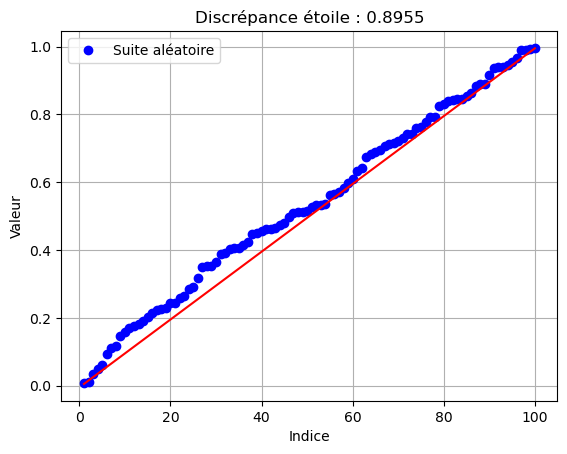

In [10]:
# Afficher la discrépance étoile de la suite
discrepancy = calculate_discrepancy_star(sequence)
size_seq = len(sequence)
print(f'La discrépance étoile est {discrepancy:.4f}.')
# Afficher la suite et la discrépance étoile
sorted_sequence = np.sort(sequence)
plt.plot(range(1,size_seq+1),sorted_sequence, 'bo', label='Suite aléatoire')
plt.plot(range(1,size_seq+1),(2*np.linspace(1,size_seq,size_seq)-1)/(2*size_seq),'r-')
plt.title(f'Discrépance étoile : {discrepancy:.4f}')
plt.xlabel('Indice')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.show()

### 3- Génération de suites déterministes à discrépance faible.

On peut générer une suite (non aléatoire) à discrépance faible. Un premier exemple consiste à utiliser une écriture en base $b$  pour générer la suite de van der Corput.

#### $\blacktriangleright$ Question 4 [code] : Définir une fonction qui permet de générer les $n$ premiers éléments de la suite de van der Corput en base $b$.

In [42]:
###################################################
# Réponse 4 [code] :
###################################################
def van_der_corput_sequence(n, base=2):
    sequence = np.zeros(n)
    for i in range(n):
        x = 0
        f = 1
        k = i + 1
        while k > 0:
            f = f/base
            x += (k % base) * f
            k = k//base
            
        sequence[i] = x
    
    return sequence

In [43]:
# Générer une séquence de Van der Corput avec 10 points (en base 2)
size_sequence = 15  # Nombre de points dans la suite
sequence = van_der_corput_sequence(size_sequence)

# Afficher les premiers points générés
print("Séquence de Van der Corput :")
for i, value in enumerate(sequence, start=1):
    print(f"Point {i}: {value:.4f}")

Séquence de Van der Corput :
Point 1: 0.5000
Point 2: 0.2500
Point 3: 0.7500
Point 4: 0.1250
Point 5: 0.6250
Point 6: 0.3750
Point 7: 0.8750
Point 8: 0.0625
Point 9: 0.5625
Point 10: 0.3125
Point 11: 0.8125
Point 12: 0.1875
Point 13: 0.6875
Point 14: 0.4375
Point 15: 0.9375


La discrépance étoile est 0.6167.


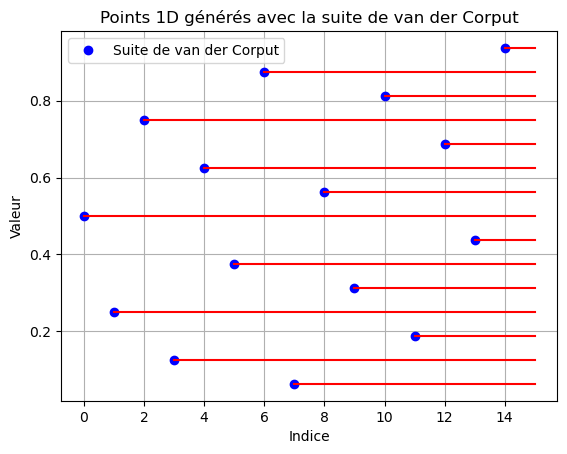

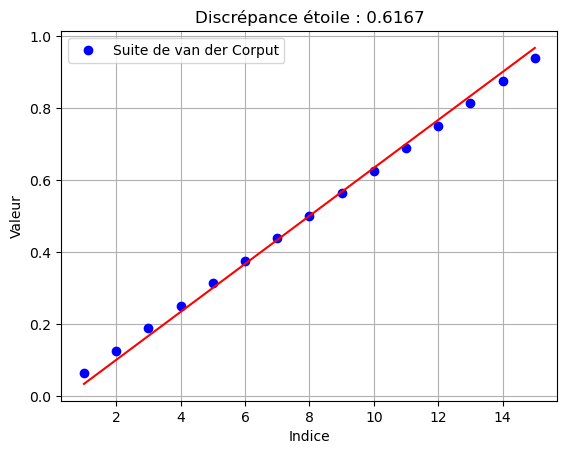

In [44]:
# Afficher la discrépance étoile de la suite
discrepancy = calculate_discrepancy_star(sequence)
size_seq = len(sequence)
print(f'La discrépance étoile est {discrepancy:.4f}.')
# Afficher la suite et son remplissage de [0,1]
plt.plot(sequence, 'bo', label='Suite de van der Corput')
for i in range(size_sequence):
    plt.plot([i,size_sequence],[sequence[i],sequence[i]],'r-')

plt.xlabel('Indice')
plt.ylabel('Valeur')
plt.title('Points 1D générés avec la suite de van der Corput')
plt.legend()
plt.grid(True)
plt.show()
# Afficher la suite et la discrépance étoile
sorted_sequence = np.sort(sequence)
plt.plot(range(1,size_seq+1),sorted_sequence, 'bo', label='Suite de van der Corput')
plt.plot(range(1,size_seq+1),(2*np.linspace(1,size_seq,size_seq)-1)/(2*size_seq),'r-')
plt.title(f'Discrépance étoile : {discrepancy:.4f}')
plt.xlabel('Indice')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.show()

#### $\blacktriangleright$ Question 4bis [code] : Définir une fonction qui permet de générer les $n$ premiers éléments de la suite de Halton en base $b=3$. Et définir une fonction qui permet de générer les suites de Halton en toutes dimensions.

Indication : Pour permettre son utilisation dans la suite du TP, on se donne le début de code suivant pour générer les suites de Halton en toutes dimensions.
Il est basé sur le calcul des nombres premiers successifs. Et on fournit une fonction de visualisation en dimensions 1 et 2.

In [33]:
###################################################
# Réponse 4bis [code] :
###################################################
# Fonction simple pour calculer la suite de Halton en dimension 1 en base 3.
def halton_sequence(n, base=3):
    sequence = np.zeros(n)
    for i in range(n):
        x = 0
        f = 1
        k = i+1
        while k > 0:
            f = f/base
            x += (k % base) * f
            k = k//base
        sequence[i] = x
    return sequence  

# Fonction pour calculer le prochain nombre premier.
def next_prime():
    prime = 2
    while True:
        yield prime
        prime += 1
        while not all(prime % np.arange(2, int(np.sqrt(prime)) + 1)):
            prime += 1

# Fonction pour calculer la suite de Halton en dimension d.
def halton_sequence_dimension(n,d):
    sequence = np.zeros((n, d))
    primes = next_prime()
    for j in range(d):
        base = next(primes)
        sequence[:, j] = halton_sequence(n, base)
    return sequence

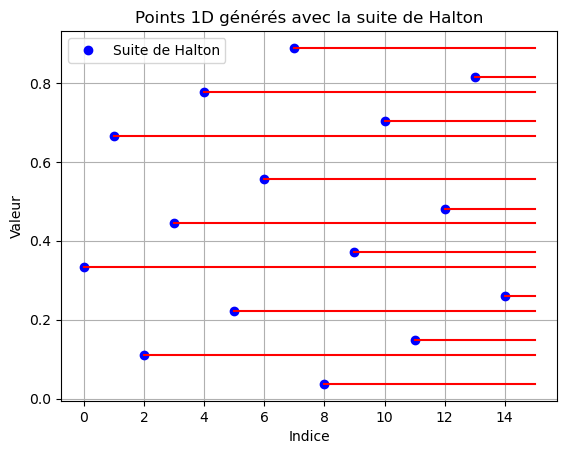

La discrépance étoile est 0.7407.


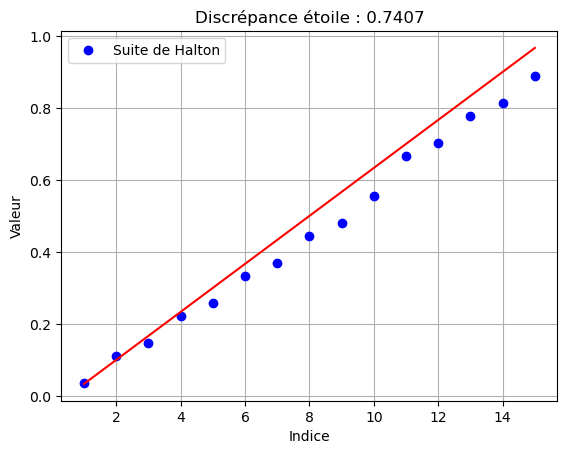

In [34]:
# Générer les premières valeurs de la suite de Halton 1D
dimension = 1
size_sequence = 15  # Nombre de points dans la suite
sequence = halton_sequence(size_sequence)

# Afficher la suite et son remplissage de [0,1]
plt.plot(sequence, 'bo', label='Suite de Halton')
for i in range(size_sequence):
    plt.plot([i,size_sequence],[sequence[i],sequence[i]],'r-')

plt.xlabel('Indice')
plt.ylabel('Valeur')
plt.title('Points 1D générés avec la suite de Halton')
plt.legend()
plt.grid(True)
plt.show()

# Afficher la discrépance étoile de la suite
discrepancy = calculate_discrepancy_star(sequence)
size_seq = len(sequence)
print(f'La discrépance étoile est {discrepancy:.4f}.')
# Afficher la suite et la discrépance étoile
sorted_sequence = np.sort(sequence)
plt.plot(range(1,size_seq+1),sorted_sequence, 'bo', label='Suite de Halton')
plt.plot(range(1,size_seq+1),(2*np.linspace(1,size_seq,size_seq)-1)/(2*size_seq),'r-')
plt.title(f'Discrépance étoile : {discrepancy:.4f}')
plt.xlabel('Indice')
plt.ylabel('Valeur')
plt.legend()
plt.grid(True)
plt.show()

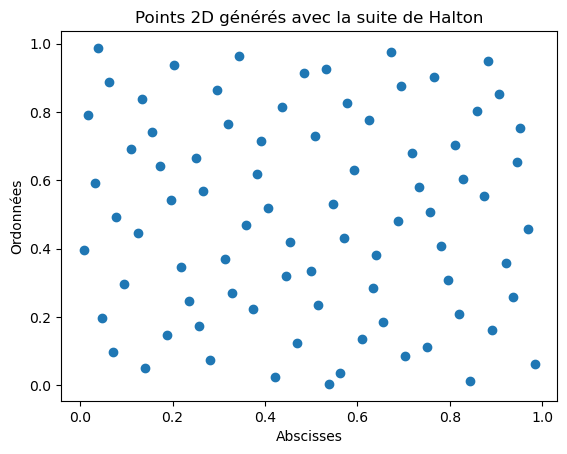

In [35]:
# Générer les premières valeurs de la suite de Halton 2D
dimension = 2
size_sequence = 81  # Nombre de points dans la suite
sequence_2D = halton_sequence_dimension(size_sequence,dimension)

# Afficher les points générés
plt.scatter(sequence_2D[:, 0], sequence_2D[:, 1], marker='o')
plt.title('Points 2D générés avec la suite de Halton')
plt.xlabel('Abscisses')
plt.ylabel('Ordonnées')
plt.show()

### 4- Calcul d'intégrales

#### $\blacktriangleright$ Question 5 [code] : Ecrire une fonction pour calculer l'intégrale d'une fonction quelconque sur l'intervalle $[0,1]$ à l'aide d'une suite donnée. 

In [46]:
###################################################
# Réponse 5 [code] :
###################################################
def compute_integral(func,sequence):
    N = len(sequence)
    sorted_sequence = np.sort(sequence)
    # for i in range(N-1):
    #     x_1 = sorted_sequence[i]
    #     x_2 = sorted_sequence[i+1]
    #     S += (func(x_1)+func(x_2))/2 * (x_2-x_1)
    # return S
    S = 0
    for i in range(N):
        S += func(sorted_sequence[i]) / N
    return S

On définit la fonction `square` suivante : 

In [47]:
def square(x):
    return x*x

#### $\blacktriangleright$ Question 6 [code] : On définit
$$
I_N(x,f) := \frac{1}{N}\sum_{n=0}^N f(x_n)
$$
#### les intégrales approchées utilisant les $N$ premiers points de la suite $x:=\{x_n\}_{n\geqslant 1}$. Tester votre code précédent en calculant l'intégrale approchée $I_N$ de la fonction $square$ sur $[0,1]$ avec les $N=1000$ premiers points des différentes suites à discrépance faible construites précédemment.

In [48]:
###################################################
# Réponse 6 [code] :
###################################################
# Générer les 3 suites à discrépance faible.
N = 1000
sequence_random = np.random.rand(N)
sequence_vandercorput = van_der_corput_sequence(N)
sequence_halton = halton_sequence(N)
# Calculer les intégrales.
result_random = compute_integral(square, sequence_random)
result_vandercorput = compute_integral(square, sequence_vandercorput)
result_halton = compute_integral(square, sequence_halton)

# Affichage des résultats
print("Intégrales calculées:", result_random, result_vandercorput, result_halton)

Intégrales calculées: 0.34573412981535734 0.33210916996002204 0.3317863987828479


#### $\blacktriangleright$ Question 7 [code] : Illustrer les vitesses de convergence de $I_N(x,f)$ vers $\int_0^1 f(u) du$ en fonction du nombre $N$ de points de chaque suite $x$. 

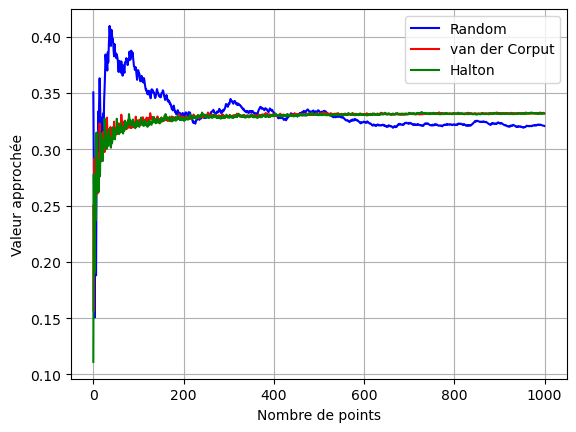

In [49]:
###################################################
# Réponse 7 [code] :
###################################################
N = 1000

func = square

results_random = np.zeros(N)
results_van_der_corput = np.zeros(N)
results_halton = np.zeros(N)
sequence_random = np.random.random(N)
sequence_van_der_corput = van_der_corput_sequence(N)
sequence_halton = halton_sequence(N)

    ##>>>> Completer <<<<##]
for i in range(N):
    results_random[i] = compute_integral(func, sequence_random[:i+1])
    results_van_der_corput[i] = compute_integral(func, sequence_van_der_corput[:i+1])
    results_halton[i] = compute_integral(func, sequence_halton[:i+1])

plt.plot(results_random, 'b-', label='Random')
plt.plot(results_van_der_corput, 'r-', label='van der Corput')
plt.plot(results_halton, 'g-', label='Halton')
plt.xlabel('Nombre de points')
plt.ylabel('Valeur approchée')
plt.legend()
plt.grid(True)
plt.show()


#### $\blacktriangleright$ Question 8 [code] : Calculer l'intégrale de la fonction Wing weight avec une suite aléatoire et la suite de Halton en dimension 10. En premier lieu, on généralisera le calcul de l'intégrale uni-dimensionnelle au cas d'une intégrale multiple sur $[0,1]^d$ en dimension $d$.

In [51]:
# Renormalisation des paramètres dans l'hypercube [0,1]^d
def wing_weight(x):
    S_w = 150 + (200-150)*x[0]
    W_fw = 220 + (300-220)*x[1]
    A = 6 + (10-6)*x[2]
    lambda_majus = (-10 + (10-(-10))*x[3])*np.pi/180
    q = 16+(45-16)*x[4]
    lambda_minus = 0.5 + (1-0.5)*x[5]
    t_c = 0.08 + (0.18-0.08)*x[6]
    N_x = 2.5 + (6-2.5)*x[7] 
    W_dg = 1700 + (2500-1700)*x[8]
    W_p = 0.025 + (0.08-0.025)*x[9]
    return 0.036 * S_w**0.758 * W_fw**0.0035 * (A / (np.cos(lambda_majus)**2))**0.6 * q**0.006 * lambda_minus**0.04 * (100 * t_c / np.cos(lambda_majus))**(-0.3) * (N_x * W_dg)**0.49 + S_w * W_p

In [53]:
###################################################
# Réponse 8 [code] :
###################################################
# Fonction pour calculer une intégrale sur l'hypercube [0,1]^d
def compute_integral_dimension(func,sequence):
    integral_value = sum(func(x) for x in sequence) / len(sequence)
    return integral_value

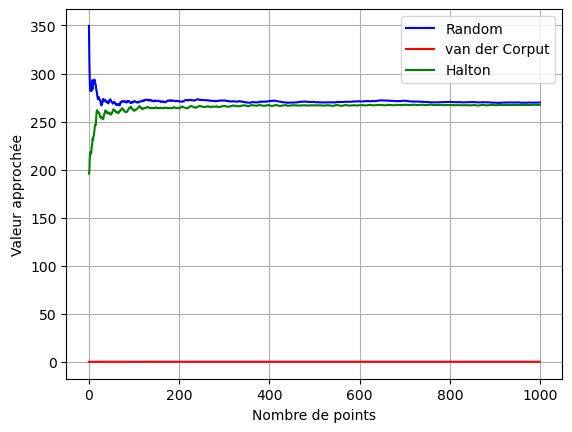

In [55]:
###################################################
# Réponse 8 [code] :
###################################################
N = 1000
d = 10

func = wing_weight

results_random = np.zeros(N)
results_halton = np.zeros(N)
sequence_random = np.random.random((N,d))
sequence_halton = halton_sequence_dimension(N,d)

for i in range(N):
    results_random[i] = compute_integral_dimension(func, sequence_random[:i+1, :])
    # results_van_der_corput[i] = compute_integral_dimension(func, sequence_van_der_corput[:i+1])
    results_halton[i] = compute_integral_dimension(func, sequence_halton[:i+1, :])

plt.plot(results_random, 'b-', label='Random')
plt.plot(results_van_der_corput, 'r-', label='van der Corput')
plt.plot(results_halton, 'g-', label='Halton')
plt.xlabel('Nombre de points')
plt.ylabel('Valeur approchée')
plt.legend()
plt.grid(True)
plt.show()

Les moyennes cumulatives de Halton semblent suivre une tendance monotone à mesure que n augmente. Une explication possible est que les moyennes cumulées des entrées ont tendance à s'approcher de 0,5 par le bas et que la fonction de poids de l'aile augmente de manière monotone dans la plupart de ses entrées. Peut-être qu'un échantillonnage antithétique avec la séquence de Halton améliorerait l'estimation du poids moyen des ailes.

#### $\blacktriangleright$ Question 9 [math+code] : Dans le cas d'une suite aléatoire, pouvez-vous donner un ordre de grandeur du comportement de $I_N$ lorsque $N$ tend vers $+\infty$ ? Simulez un échantillon de taille $M$ de variables aléatoires $I_N$ avec $N$ et $M$ grands pour vérifier votre conjecture. On pourra s'appuyer sur les résultats fournis par la loi forte des grand nombres et le théorème central limite.

In [ ]:
###################################################
# Réponse 9 [code] :
###################################################
N = 100 # Taille de la suite aléatoire ou à discrépance faible.
M = 1000 # Taille de l'échantillon pour l'estimation Monte-Carlo.
####################################################
I_N = np.zeros(M)

    ##>>>> Completer <<<<##   

exact = 0
####################################################
# Affichage des valeurs aléatoires
plt.plot(I_N, label="Estimation I_N")
plt.plot([1,M],[exact,exact],label="Valeur exacte")
plt.legend(loc="best")

In [ ]:
###################################################
# Réponse 9 [code] :
###################################################
N = 100 # Taille de la suite aléatoire ou à discrépance faible.
M = 1000 # Taille de l'échantillon pour l'estimation Monte-Carlo.
####################################################

    ##>>>> Completer <<<<##   

####################################################
# Affichage
plt.hist(erreurNormalisee_N, density="True", bins=int(np.sqrt(M)), label="erreur normalisée")
x = np.linspace(-5,5,100)
densiteGaussienne = np.exp(-x*x/2.) / np.sqrt(2. * np.pi)
plt.plot(x,densiteGaussienne, color="red", label="densité gaussienne", linewidth=2.0)
plt.legend(loc="best")

#### $\blacktriangleright$ Question 10 [math+code] ($\textcolor{red}{optional}$) : Dans le cas de la suite de Halton ou de van der Corput, pouvez-vous donner un ordre de l'ordre de convergence de $I_N$ lorsque $N$ tend vers $+\infty$ 

In [ ]:
###################################################
# Réponse 10 [code] :
###################################################
# Module de continuité de la fonction étudiée.
def continuity_modulus(x):
    return 0

####################################################
N = 100 # Taille maximale de la suite à discrépance faible.

I_N = np.zeros(N)
D_N = np.zeros(N)
MD_N = np.zeros(N)

sequence_van_der_corput = van_der_corput_sequence(N)

for n in range(N):
    
    ##>>>> Completer <<<<##   

exact = 0

####################################################
plt.plot(abs(I_N-exact), color="blue",label="van der Corput")
plt.plot(D_N, color="red",label="Discrépance star")
plt.plot(MD_N, color="green",label="M(Discrépance star)")

plt.legend(loc="best")

La dernière étape consiste à ajouter un comportement aléatoire à la suite de discrépance faible pour bénéficier de nouveau des intervalles de confiance. Dans le temps restant, vous pouvez développer une version "randomisée" des suites à discrépance faible et étudier leur comportement asymptotique.